## Imports

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import re
from itertools import cycle
import json
import urllib.request

import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import pandas_profiling

from wordcloud import WordCloud

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

/tmp/ipykernel_341/2321084470.py:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


## Data Preparation

In [3]:
train_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])
test_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/test.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])
val_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/dev.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])


In [4]:
train_df

Text Emotion
0      My favourite food is anything I didn't have to...      27
1      Now if he does off himself, everyone will thin...      27
2                         WHY THE FUCK IS BAYLESS ISOING       2
3                            To make her feel threatened      14
4                                 Dirty Southern Wankers       3
...                                                  ...     ...
43405  Added you mate well I’ve just got the bow and ...      18
43406  Always thought that was funny but is it a refe...       6
43407  What are you talking about? Anything bad that ...       3
43408            More like a baptism, with sexy results!      13
43409                                    Enjoy the ride!      17

[43410 rows x 2 columns]

In [5]:
with urllib.request.urlopen('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/emotions.txt') as f:
  emotion_list = f.read().decode().split("\n")

with urllib.request.urlopen('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/ekman_mapping.json') as f:
    contents = f.read()
    ekman_mapping = json.loads(contents)
    ekman_mapping["neutral"] = ["neutral"]

ekman_dict = {v:k for k, values in ekman_mapping.items() for v in values}

In [6]:
ekman_dict

{'anger': 'anger',
 'annoyance': 'anger',
 'disapproval': 'anger',
 'disgust': 'disgust',
 'fear': 'fear',
 'nervousness': 'fear',
 'joy': 'joy',
 'amusement': 'joy',
 'approval': 'joy',
 'excitement': 'joy',
 'gratitude': 'joy',
 'love': 'joy',
 'optimism': 'joy',
 'relief': 'joy',
 'pride': 'joy',
 'admiration': 'joy',
 'desire': 'joy',
 'caring': 'joy',
 'sadness': 'sadness',
 'disappointment': 'sadness',
 'embarrassment': 'sadness',
 'grief': 'sadness',
 'remorse': 'sadness',
 'surprise': 'surprise',
 'realization': 'surprise',
 'confusion': 'surprise',
 'curiosity': 'surprise',
 'neutral': 'neutral'}

In [6]:
def get_emotion(emotion_label):
    """Function to replace emotions labels with the simplified ekamn mapping"""
    emotion_label = emotion_label.split(",")[0]
    emotion = emotion_list[int(emotion_label)]
    # return emotion after ekman mapping
    return ekman_dict[emotion]

train_df["Emotion"] = train_df["Emotion"].apply(get_emotion)
test_df["Emotion"] = test_df["Emotion"].apply(get_emotion)
val_df["Emotion"] = val_df["Emotion"].apply(get_emotion)

In [7]:
train_df

Text   Emotion
0      My favourite food is anything I didn't have to...   neutral
1      Now if he does off himself, everyone will thin...   neutral
2                         WHY THE FUCK IS BAYLESS ISOING     anger
3                            To make her feel threatened      fear
4                                 Dirty Southern Wankers     anger
...                                                  ...       ...
43405  Added you mate well I’ve just got the bow and ...       joy
43406  Always thought that was funny but is it a refe...  surprise
43407  What are you talking about? Anything bad that ...     anger
43408            More like a baptism, with sexy results!       joy
43409                                    Enjoy the ride!       joy

[43410 rows x 2 columns]

## Data Exploratory Analysis

In [9]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [10]:
train_df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
test_df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
fig = px.box(train_df["Text"].str.split().apply(len),
       color=train_df["Emotion"],
       template='plotly_white',
       title="Text Lengths in the Train Data",
       )

fig.update_layout(xaxis_title='Emotion', yaxis_title='Lengths of Texts')

fig.show()

In [17]:
fig = px.box(test_df["Text"].str.split().apply(len),
       color=test_df["Emotion"],
       template='plotly_dark',
       title="Text Lengths in the Test Data",
       )

fig.update_layout(xaxis_title='Emotion', yaxis_title='Lengths of Texts')

fig.show()

In [26]:
fig = px.box(val_df["Text"].str.split().apply(len),
       color=val_df["Emotion"],
       template='ggplot2',
       title="Text Lengths in the Validation Data",
       )

fig.update_layout(xaxis_title='Emotion', yaxis_title='Lengths of Texts')

fig.show()

## Data Preprocessing

In [8]:
train_df = train_df.drop_duplicates("Text")
test_df = test_df.drop_duplicates("Text")
val_df = val_df.drop_duplicates("Text")

In [31]:
print("Shape 'before' removal of lower order emotions in train_df : ",train_df.shape)

Shape before removal of lower order emotions in train_df :  (43227, 2)


In [9]:
train_df = train_df[train_df['Emotion'].isin(['fear', 'disgust']) == False]
test_df = test_df[test_df['Emotion'].isin(['fear', 'disgust']) == False]
val_df = val_df[val_df['Emotion'].isin(['fear', 'disgust']) == False]

In [34]:
print("Shape 'after' removal of lower order emotions in train_df : ",train_df.shape)

Shape 'after' removal of lower order emotions in train_df :  (42036, 2)


In [10]:
onehotval = preprocessing.OneHotEncoder()
y_train = onehotval.fit_transform(train_df["Emotion"].values.reshape(-1,1))
y_test = onehotval.transform(test_df["Emotion"].values.reshape(-1,1))
y_val = onehotval.transform(val_df["Emotion"].values.reshape(-1,1))

In [11]:
y_train = tf.convert_to_tensor(csr_matrix(y_train).todense(), tf.float32)
y_test = tf.convert_to_tensor(csr_matrix(y_test).todense(), tf.float32)
y_val = tf.convert_to_tensor(csr_matrix(y_val).todense(), tf.float32)

## Creating TF datset

In [12]:
train_ds =  tf.data.Dataset.from_tensor_slices((train_df["Text"], y_train)).shuffle(buffer_size=1000).batch(32)
val_ds =  tf.data.Dataset.from_tensor_slices((val_df["Text"], y_val)).shuffle(buffer_size=1000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["Text"], y_test))

In [55]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Text: {text_batch.numpy()[i]}')
    label = np.argmax(label_batch.numpy()[i])
    print(f'Label : {label} ({onehotval.categories_[0][label]})')

Text: b"How did you try it if it's not live yet? There was no early access to it"
Label : 2 (neutral)
Text: b"What? That's exactly what I got from it. Obviously red-haired people are just defective and need to be cured/corrected. /sssssssssssssssssssssssssssss"
Label : 2 (neutral)
Text: b'Nice try with your 1/3 pan and t rex arms there buckaroo /s'
Label : 1 (joy)


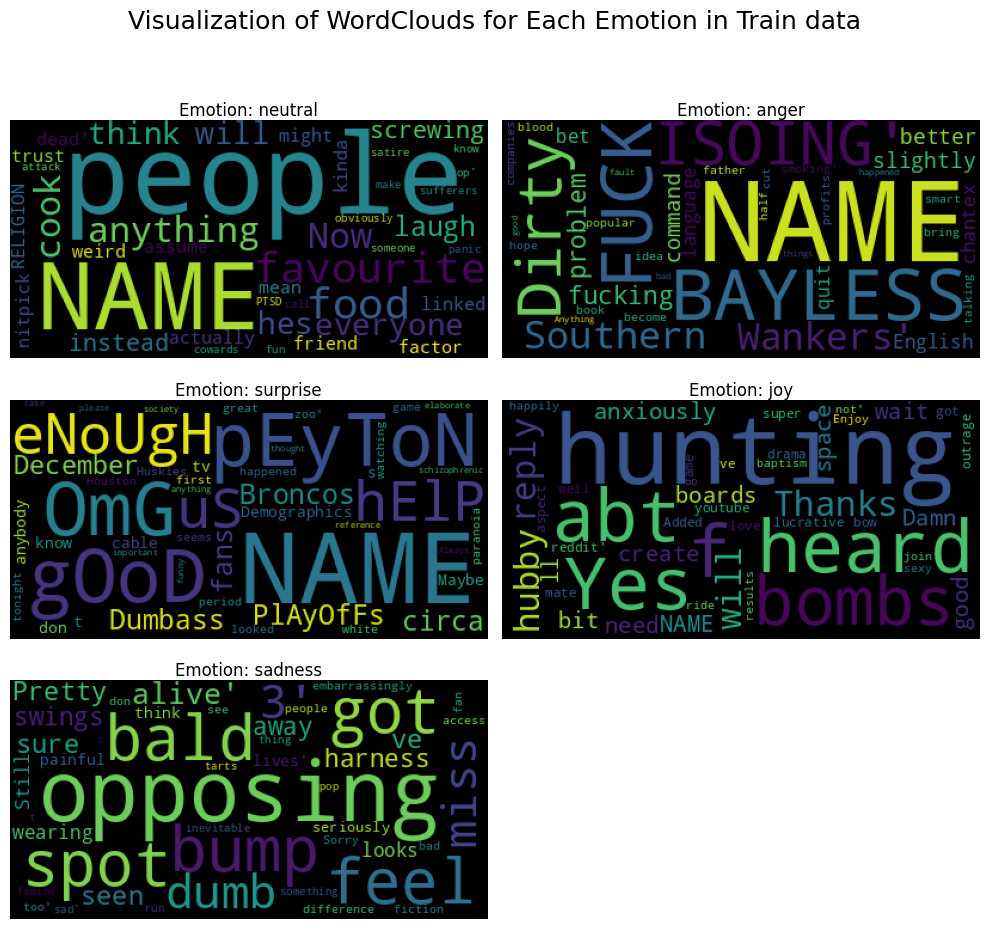

In [56]:
fig = plt.figure(figsize = (10,10))
    
rows = 3
columns = 2    
for idx, emotion in enumerate(train_df["Emotion"].unique()):
    ax = plt.subplot(rows, columns, idx+1)
    wc = WordCloud().generate(str(train_df[train_df["Emotion"] == emotion]["Text"].values))
    plt.imshow(wc) 
    ax.set_title(f"Emotion: {emotion}", verticalalignment="top")
    plt.axis("off")
    
fig.suptitle(f"Visualization of WordClouds for Each Emotion in Train data", size=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

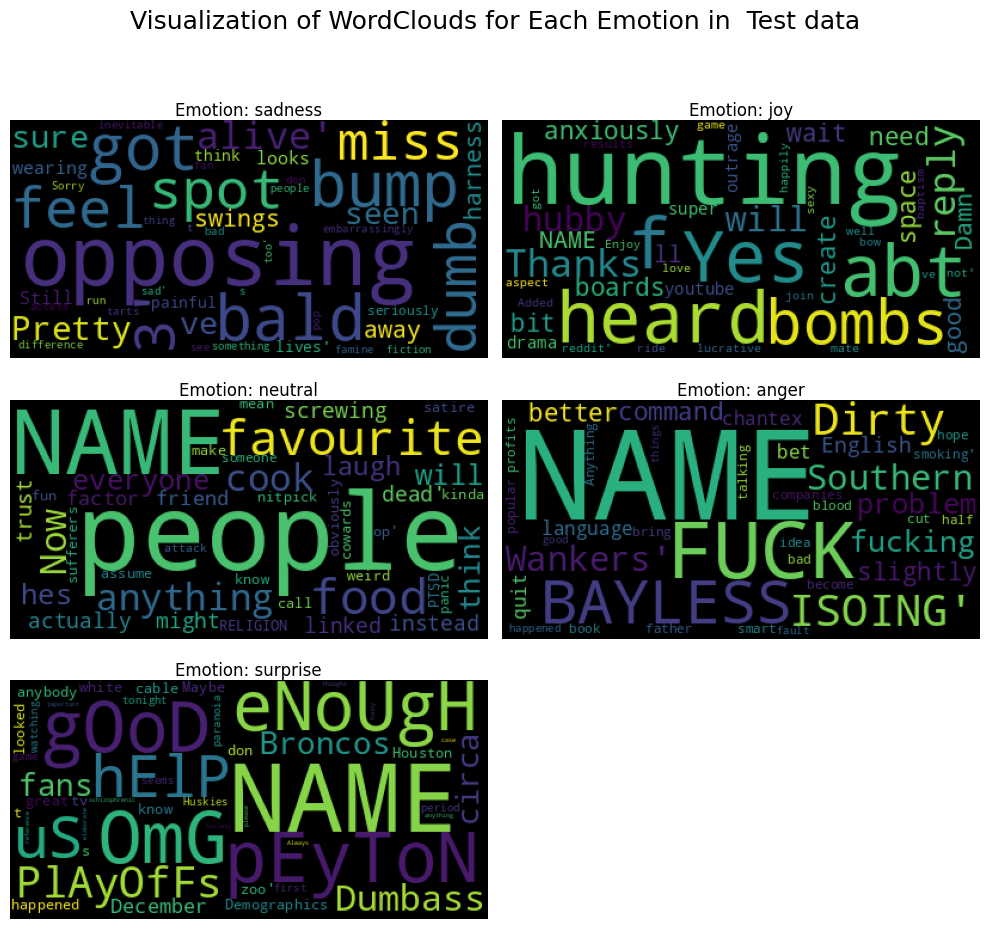

In [57]:
fig = plt.figure(figsize = (10,10))
    
rows = 3
columns = 2    
for idx, emotion in enumerate(test_df["Emotion"].unique()):
    ax = plt.subplot(rows, columns, idx+1)
    wc = WordCloud().generate(str(train_df[train_df["Emotion"] == emotion]["Text"].values))
    plt.imshow(wc) 
    ax.set_title(f"Emotion: {emotion}", verticalalignment="top")
    plt.axis("off")
    
fig.suptitle(f"Visualization of WordClouds for Each Emotion in  Test data", size=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model Training

In [45]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [97]:
def build_bert_model():
#   Function which returns a built model

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  preprocessor = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
        trainable=True,
        name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(128, activation="relu")(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(64, activation="relu")(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation="softmax", name='classifier')(net)
    
  return tf.keras.Model(text_input, net)

In [89]:
model = build_bert_model()

In [98]:
model2 = build_bert_model()

## Training

### Custom Bert Model to compare with non-mobile compute models

In [90]:
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer="adam", loss=loss, metrics="accuracy")

In [99]:
loss = tf.keras.losses.CategoricalCrossentropy()
model2.compile(optimizer="adam", loss=loss, metrics="accuracy")

In [91]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(x=train_ds,validation_data=val_ds,epochs=20, callbacks=[callback])


Epoch 1/20
1314/1314 [==============================] - 150s 112ms/step - loss: 1.1976 - accuracy: 0.5409 - val_loss: 1.0877 - val_accuracy: 0.5866
Epoch 2/20
1314/1314 [==============================] - 144s 110ms/step - loss: 1.1625 - accuracy: 0.5499 - val_loss: 1.1482 - val_accuracy: 0.5600
Epoch 3/20
1314/1314 [==============================] - 148s 113ms/step - loss: 1.1325 - accuracy: 0.5717 - val_loss: 1.0932 - val_accuracy: 0.5914
Epoch 4/20
1314/1314 [==============================] - 147s 112ms/step - loss: 1.0984 - accuracy: 0.5897 - val_loss: 1.1144 - val_accuracy: 0.5646
Epoch 5/20
1314/1314 [==============================] - 147s 112ms/step - loss: 1.1275 - accuracy: 0.5796 - val_loss: 1.1122 - val_accuracy: 0.5906
Epoch 6/20
1314/1314 [==============================] - 145s 110ms/step - loss: 1.1272 - accuracy: 0.5810 - val_loss: 1.0827 - val_accuracy: 0.5999
Epoch 7/20
1314/1314 [==============================] - 149s 114ms/step - loss: 1.1008 - accuracy: 0.5870 - val_

In [101]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = model2.fit(x=train_ds,validation_data=val_ds,epochs=20, callbacks=[callback])


Epoch 1/20
1314/1314 [==============================] - 148s 113ms/step - loss: 1.1653 - accuracy: 0.5676 - val_loss: 1.0713 - val_accuracy: 0.6115
Epoch 2/20
1314/1314 [==============================] - 148s 112ms/step - loss: 1.1144 - accuracy: 0.5925 - val_loss: 1.0692 - val_accuracy: 0.6026
Epoch 3/20
1314/1314 [==============================] - 148s 112ms/step - loss: 1.0961 - accuracy: 0.6012 - val_loss: 1.0553 - val_accuracy: 0.6166
Epoch 4/20
1314/1314 [==============================] - 147s 111ms/step - loss: 1.0768 - accuracy: 0.6049 - val_loss: 1.0860 - val_accuracy: 0.5933
Epoch 5/20
1314/1314 [==============================] - 146s 111ms/step - loss: 1.0758 - accuracy: 0.6107 - val_loss: 1.0966 - val_accuracy: 0.5942
Epoch 6/20
1314/1314 [==============================] - 150s 114ms/step - loss: 1.1119 - accuracy: 0.5919 - val_loss: 1.0846 - val_accuracy: 0.6018
Epoch 7/20
1314/1314 [==============================] - 145s 111ms/step - loss: 1.0679 - accuracy: 0.6186 - val_

In [113]:
model2.save('./regular_bert/bet_model')

2023-04-22 16:15:18.975531: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./regular_bert/bet_model/assets


INFO:tensorflow:Assets written to: ./regular_bert/bet_model/assets


In [92]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

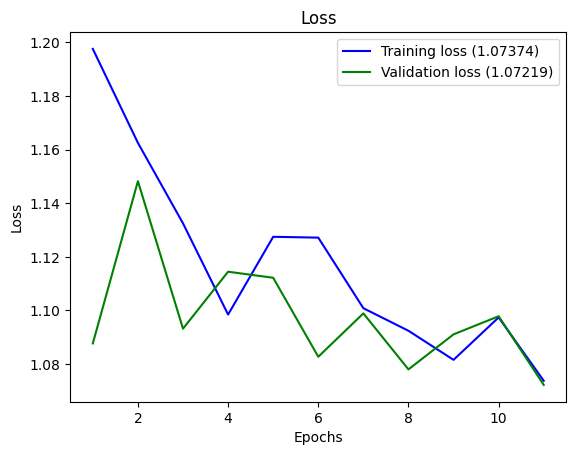

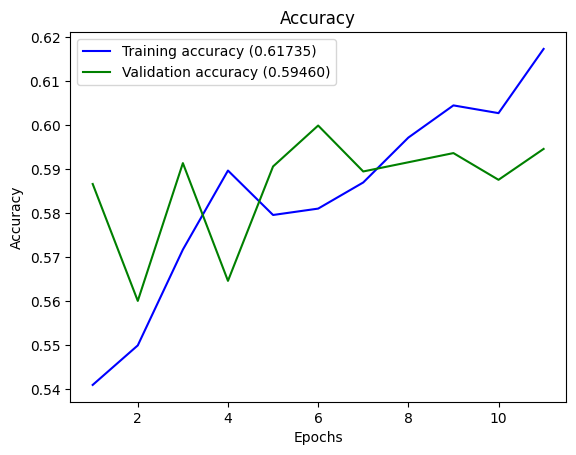

In [93]:
plot_history(history)

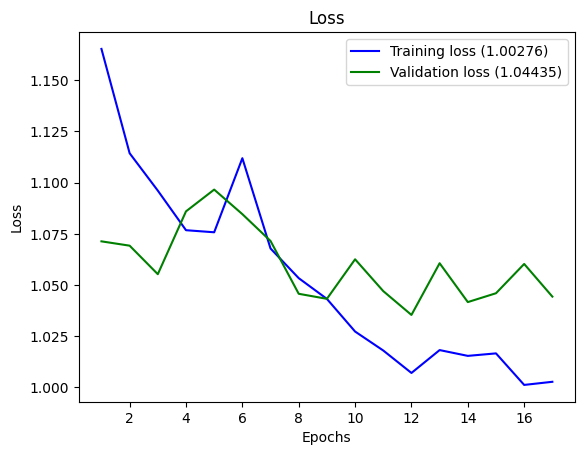

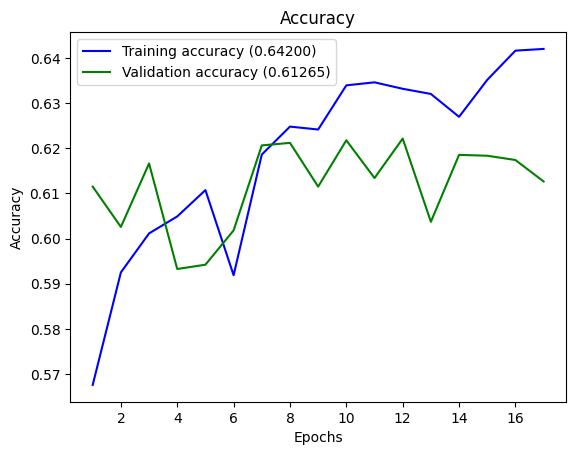

In [103]:
plot_history(history)

In [104]:
test_predictions = model2.predict(test_df["Text"])
# Get the Single labels from predction instead of an array of probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_labels = np.argmax(y_test, axis=1)

In [96]:
test_df

Text  Emotion
0     I’m really sorry about your situation :( Altho...  sadness
1       It's wonderful because it's awful. At not with.      joy
2     Kings fan here, good luck to you guys! Will be...      joy
3     I didn't know that, thank you for teaching me ...      joy
4     They got bored from haunting earth for thousan...  neutral
...                                                 ...      ...
5422  Thanks. I was diagnosed with BP 1 after the ho...      joy
5423                             Well that makes sense.      joy
5424                                Daddy issues [NAME]  neutral
5425  So glad I discovered that subreddit a couple m...      joy
5426  Had to watch "Elmo in Grouchland" one time too...  neutral

[5247 rows x 2 columns]

In [105]:
test_acc = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy is {test_acc*100}%")

Test Accuracy is 61.7305126739089%


In [108]:
print(classification_report(test_labels, test_predictions, target_names=onehotval.categories_[0]))

              precision    recall  f1-score   support

       anger       0.53      0.31      0.40       703
         joy       0.73      0.79      0.76      2049
     neutral       0.54      0.62      0.58      1605
     sadness       0.53      0.42      0.46       317
    surprise       0.52      0.48      0.50       573

    accuracy                           0.62      5247
   macro avg       0.57      0.52      0.54      5247
weighted avg       0.61      0.62      0.61      5247



In [109]:
train_df.to_csv('./goemotions/train_goemotions.csv',header=True,index=False)
test_df.to_csv('./goemotions/test_goemotions.csv',header=True,index=False)
val_df.to_csv('./goemotions/val_goemotions.csv',header=True,index=False)

### Bert Classifier
BERT (Bidirectional Encoder Representations from Transformers) is a natural language processing (NLP) model proposed by researchers at Google Research in 2018. It is a pre-trained deep learning model that can be fine-tuned for various NLP tasks such as question answering, text classification, and named entity recognition. 

BERT uses a method of masked language modeling to keep the word in focus from "seeing itself" -- that is, having a fixed meaning independent of its context. BERT is then forced to identify the masked word based on context alone. In BERT words are defined by their surroundings, not by a pre-fixed identity. 

The BERT model works like most deep learning models for ImageNet work. First, the BERT model is trained on a large corpus of text data using the masked language modeling task. Then, it is fine-tuned for a specific NLP task by adding a few extra layers at the end.

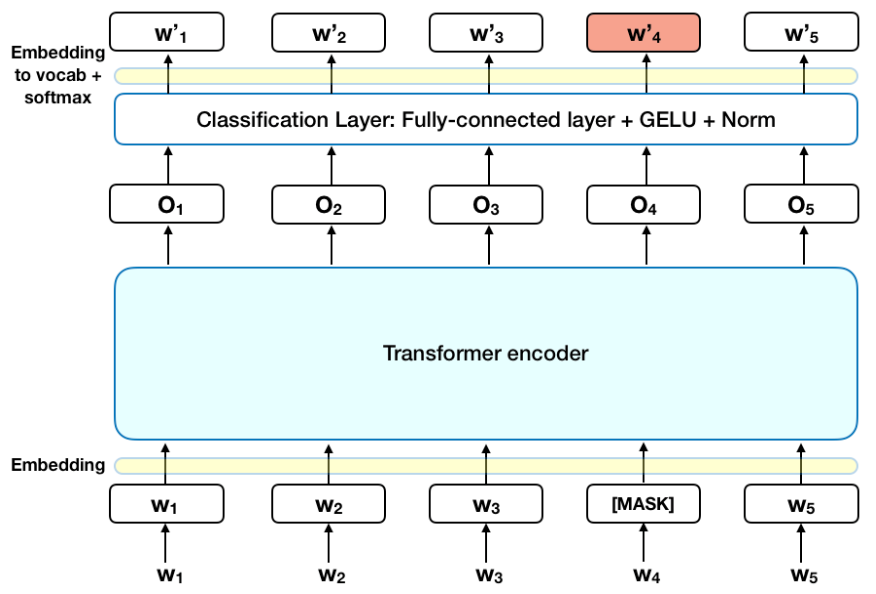

In [1]:
from tflite_model_maker import model_spec
from tflite_model_maker import text_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.text_classifier import BertClassifierSpec
from tflite_model_maker.text_classifier import DataLoader


mb_spec = model_spec.get('bert_classifier')

train_data = DataLoader.from_csv( 
      filename='./goemotions/train_goemotions.csv',
      text_column='Text',
      label_column='Emotion',
      model_spec=mb_spec,
      is_training=True)
val_data = DataLoader.from_csv(
      filename='./goemotions/val_goemotions.csv',
      text_column='Text',
      label_column='Emotion',
      model_spec=mb_spec,
      is_training=False)
      
test_data = DataLoader.from_csv(
      filename='./goemotions/test_goemotions.csv',
      text_column='Text',
      label_column='Emotion',
      model_spec=mb_spec,
      is_training=False)


In [2]:
model = text_classifier.create(train_data, validation_data=val_data,model_spec=mb_spec, epochs=2)
loss, acc = model.evaluate(test_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


1313/1313 [==============================] - 342s 250ms/step - loss: 0.8968 - test_accuracy: 0.6482 - val_loss: 0.7659 - val_test_accuracy: 0.7006
Epoch 2/2
164/164 [==============================] - 21s 124ms/step - loss: 0.8113 - test_accuracy: 0.6964


In [ ]:
model.export(export_dir='./tflite_models/bert_classifier/')
model.export(export_dir='/tflite_models/bert_classifier/',export_format=[ExportFormat.LABEL, ExportFormat.VOCAB])

In [27]:
from tflite_support.task import text

classifier = text.BertNLClassifier.create_from_file('./tflite_models/bert_classifier/model.tflite')
sentence = ""
text_classification_result = classifier.classify(sentence)
text_classification_result = text_classification_result.classifications[0].categories
print('Sentence :', sentence)
print(text_classification_result)
max_prob = max(text_classification_result[0].score, text_classification_result[1].score,text_classification_result[3].score,text_classification_result[4].score,text_classification_result[2].score)
print('Result :', [result.category_name for result in text_classification_result if result.score == max_prob][0])

Sentence : nothing much i just went to a concert and came back it was so much fun
[Category(index=0, score=0.0023520467802882195, display_name='', category_name='anger'), Category(index=0, score=0.9824376702308655, display_name='', category_name='joy'), Category(index=0, score=0.011775566264986992, display_name='', category_name='neutral'), Category(index=0, score=0.0007181743858382106, display_name='', category_name='sadness'), Category(index=0, score=0.0027165254577994347, display_name='', category_name='surprise')]
Result : joy


### MobileBert Classifier

The MobileBERT model was proposed in MobileBERT: a Compact Task-Agnostic BERT for Resource-Limited Devices by Zhiqing Sun, Hongkun Yu, Xiaodan Song, Renjie Liu, Yiming Yang, and Denny Zhou. It’s a bidirectional transformer based on the BERT model, which is compressed and accelerated using several approaches.

MobileBERT is a compressed and accelerated version of the popular BERT model that can be deployed on resource-limited mobile devices1. It was proposed to address the heavy model sizes and high latency of huge pre-trained models with hundreds of millions of parameters used in natural language processing (NLP). Like the original BERT, MobileBERT is task-agnostic and can be generically applied to various downstream NLP tasks.

The MobileBERT model uses a teacher-student training strategy where a smaller student model is trained to mimic the behavior of a larger teacher model. The teacher model is first trained on a large corpus of text data using the standard BERT training procedure. The student model is then trained to mimic the behavior of the teacher model by minimizing the difference between their outputs on a set of training examples. The student model is designed to be smaller and faster than the teacher model by using techniques such as knowledge distillation and dimensionality reduction.

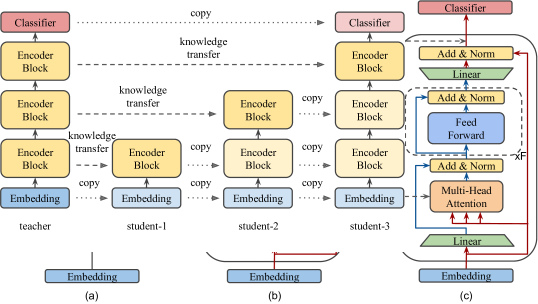

In [28]:
mb_spec = model_spec.get('mobilebert_classifier')

train_data = DataLoader.from_csv( 
      filename='./goemotions/train_goemotions.csv',
      text_column='Text',
      label_column='Emotion',
      model_spec=mb_spec,
      is_training=True)
val_data = DataLoader.from_csv(
      filename='./goemotions/val_goemotions.csv',
      text_column='Text',
      label_column='Emotion',
      model_spec=mb_spec,
      is_training=False)
      
test_data = DataLoader.from_csv(
      filename='./goemotions/test_goemotions.csv',
      text_column='Text',
      label_column='Emotion',
      model_spec=mb_spec,
      is_training=False)

In [31]:
model = text_classifier.create(train_data, validation_data=val_data,model_spec=mb_spec, epochs=3)
loss, acc = model.evaluate(test_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


875/875 [==============================] - 360s 373ms/step - loss: 1.3305 - test_accuracy: 0.5562 - val_loss: 0.8249 - val_test_accuracy: 0.6812
Epoch 2/2
875/875 [==============================] - 326s 371ms/step - loss: 0.7665 - test_accuracy: 0.7021 - val_loss: 0.7956 - val_test_accuracy: 0.6913
Epoch 3/3
164/164 [==============================] - 15s 89ms/step - loss: 0.8092 - test_accuracy: 0.6958


In [33]:
model.export(export_dir='./tflite_models/mobilebert_classifier/')
# model.export(export_dir='/tflite_models/mobilebert_classifier/',export_format=[ExportFormat.LABEL, ExportFormat.VOCAB])

INFO:tensorflow:Assets written to: /tmp/tmpuj5f3iez/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpuj5f3iez/saved_model/assets


Estimated count of arithmetic ops: 5.511 G  ops, equivalently 2.755 G  MACs


2023-04-23 12:15:18.671010: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-04-23 12:15:18.671052: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


INFO:tensorflow:Vocab file and label file are inside the TFLite model with metadata.


INFO:tensorflow:Vocab file and label file are inside the TFLite model with metadata.


INFO:tensorflow:Saved vocabulary in /tmp/tmpw38s08l6/vocab.txt.


INFO:tensorflow:Saved vocabulary in /tmp/tmpw38s08l6/vocab.txt.


INFO:tensorflow:Saving labels in /tmp/tmpw38s08l6/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpw38s08l6/labels.txt


INFO:tensorflow:Finished populating metadata and associated file to the model:


INFO:tensorflow:Finished populating metadata and associated file to the model:


INFO:tensorflow:./tflite_models/mobilebert_classifier/model.tflite


INFO:tensorflow:./tflite_models/mobilebert_classifier/model.tflite


INFO:tensorflow:The associated file that has been been packed to the model is:


INFO:tensorflow:The associated file that has been been packed to the model is:


INFO:tensorflow:['vocab.txt', 'labels.txt']


INFO:tensorflow:['vocab.txt', 'labels.txt']


INFO:tensorflow:TensorFlow Lite model exported successfully: ./tflite_models/mobilebert_classifier/model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./tflite_models/mobilebert_classifier/model.tflite
